<a href="https://colab.research.google.com/github/OJB-Quantum/Notebooks-for-Ideas/blob/main/LUMO_Based_Readout_for_Cluster_Ensembles.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Detected crossings near (V): [0.5   0.776]


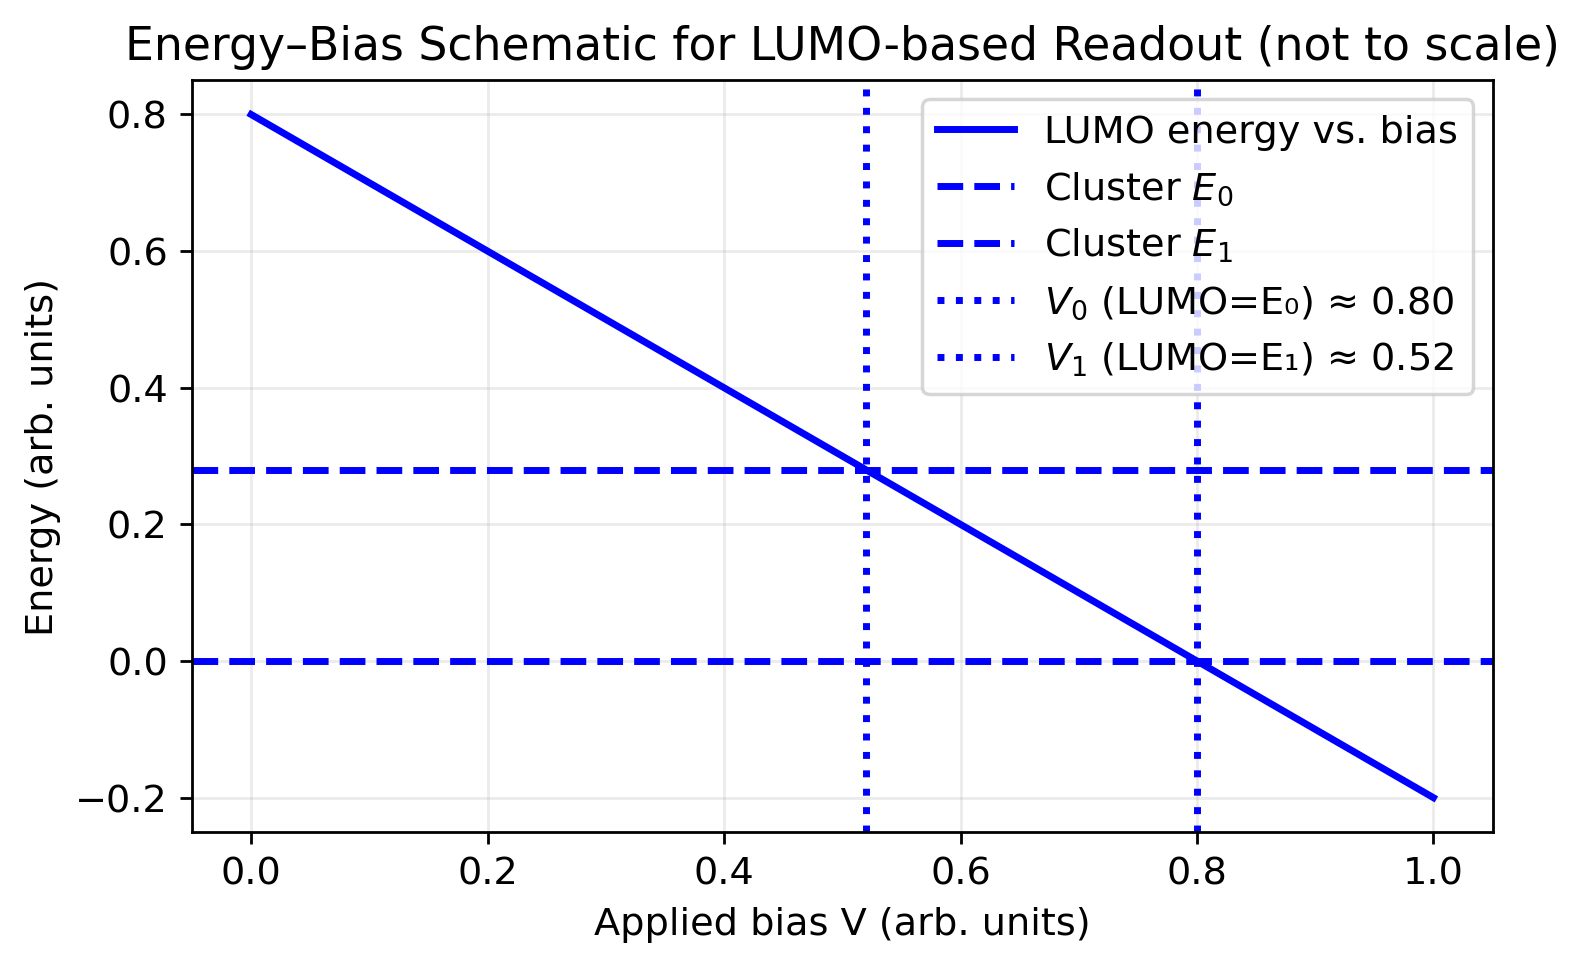

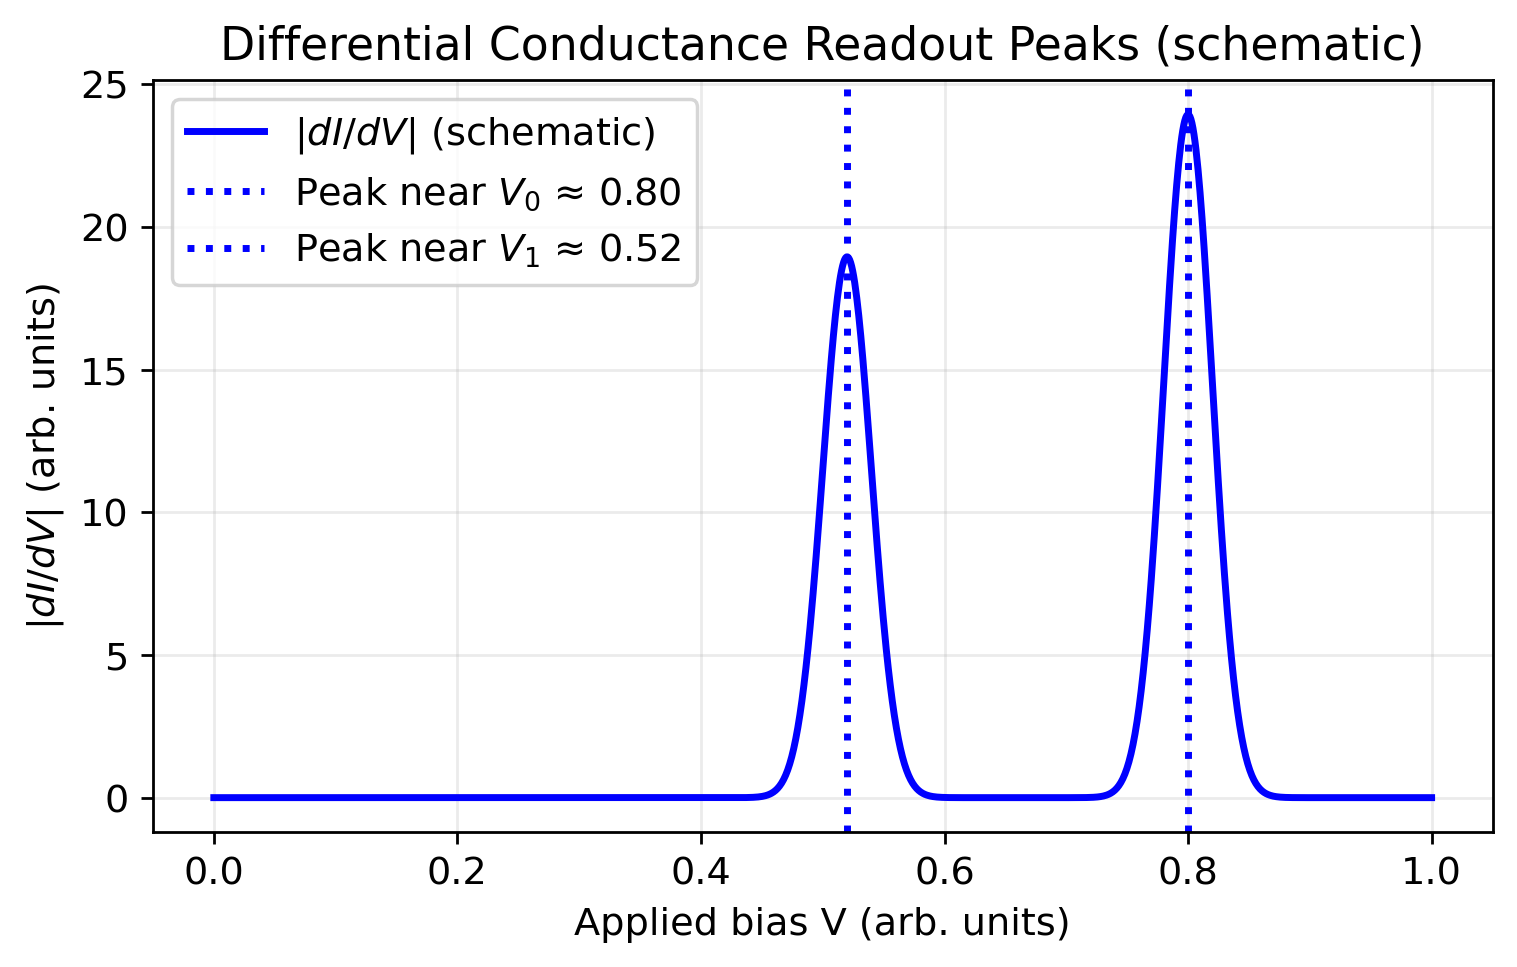

In [32]:
# LUMO-based readout: energy–bias schematic + |dI/dV| peaks

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# --- Global style (200 dpi via rcParams) ---
mpl.rcParams["figure.dpi"] = 250

# --- Tunables (schematic, not calibrated to a specific device) ---
E0 = 0.00        # cluster ground-state energy (arb. units)
E1 = 0.28        # first excited-state energy (arb. units)
epsilon = 0.80   # LUMO on-site energy offset (arb. units)
e_charge = 1.0   # normalized electron charge so slope dE/dV = -1
V_min, V_max = 0.0, 1.0
N = 1200

# --- LUMO energy vs. bias: E_LUMO(V) = epsilon - e*V ---
V = np.linspace(V_min, V_max, N)
E_LUMO = epsilon - e_charge * V

def bias_at_crossing(E_level, eps=epsilon, e=e_charge):
    """Bias where the LUMO line crosses a given cluster level E_level."""
    return (eps - E_level) / e

V0 = bias_at_crossing(E0)
V1 = bias_at_crossing(E1)

# --- Figure 1: Energy–bias schematic ---
fig1 = plt.figure(figsize=(6.2, 4.0))
ax1 = fig1.add_subplot(111)

ax1.plot(V, E_LUMO, color="blue", label="LUMO energy vs. bias")
ax1.axhline(E0, linestyle="--", color="blue", label=r"Cluster $E_0$")
ax1.axhline(E1, linestyle="--", color="blue", label=r"Cluster $E_1$")
ax1.axvline(V0, linestyle=":", color="blue", label=fr"$V_0$ (LUMO=E₀) ≈ {V0:.2f}")
ax1.axvline(V1, linestyle=":", color="blue", label=fr"$V_1$ (LUMO=E₁) ≈ {V1:.2f}")

ax1.set_title("Energy–Bias Schematic for LUMO-based Readout (not to scale)")
ax1.set_xlabel("Applied bias V (arb. units)")
ax1.set_ylabel("Energy (arb. units)")
ax1.legend(loc="best")
fig1.tight_layout()
# (Optional) save:
# fig1.savefig("lumo_energy_diagram.png")

# --- Figure 2: Differential conductance (schematic) ---
def gaussian(x, mu, sigma):
    return np.exp(-0.5 * ((x - mu) / sigma) ** 2) / (sigma * np.sqrt(2.0 * np.pi))

sigma = 0.02  # peak width (arb.)
dIdV = 1.20 * gaussian(V, V0, sigma) + 0.95 * gaussian(V, V1, sigma)

fig2 = plt.figure(figsize=(6.2, 4.0))
ax2 = fig2.add_subplot(111)

ax2.plot(V, dIdV, color="blue", label=r"$|dI/dV|$ (schematic)")
ax2.axvline(V0, linestyle=":", color="blue", label=fr"Peak near $V_0$ ≈ {V0:.2f}")
ax2.axvline(V1, linestyle=":", color="blue", label=fr"Peak near $V_1$ ≈ {V1:.2f}")

ax2.set_title("Differential Conductance Readout Peaks (schematic)")
ax2.set_xlabel("Applied bias V (arb. units)")
ax2.set_ylabel(r"$|dI/dV|$ (arb. units)")
ax2.legend(loc="best")
fig2.tight_layout()
fig2.savefig("lumo_dIdV_peaks.png")

# --- Optional: simple threshold detect on the |dI/dV| curve (text output) ---
thr = 0.5 * dIdV.max()
crossings = np.where((dIdV[1:] >= thr) & (dIdV[:-1] < thr))[0]
if crossings.size:
    approx_peaks = V[crossings]
    print("Detected crossings near (V):", np.round(approx_peaks, 3))
else:
    print("No crossings found at the chosen threshold.")

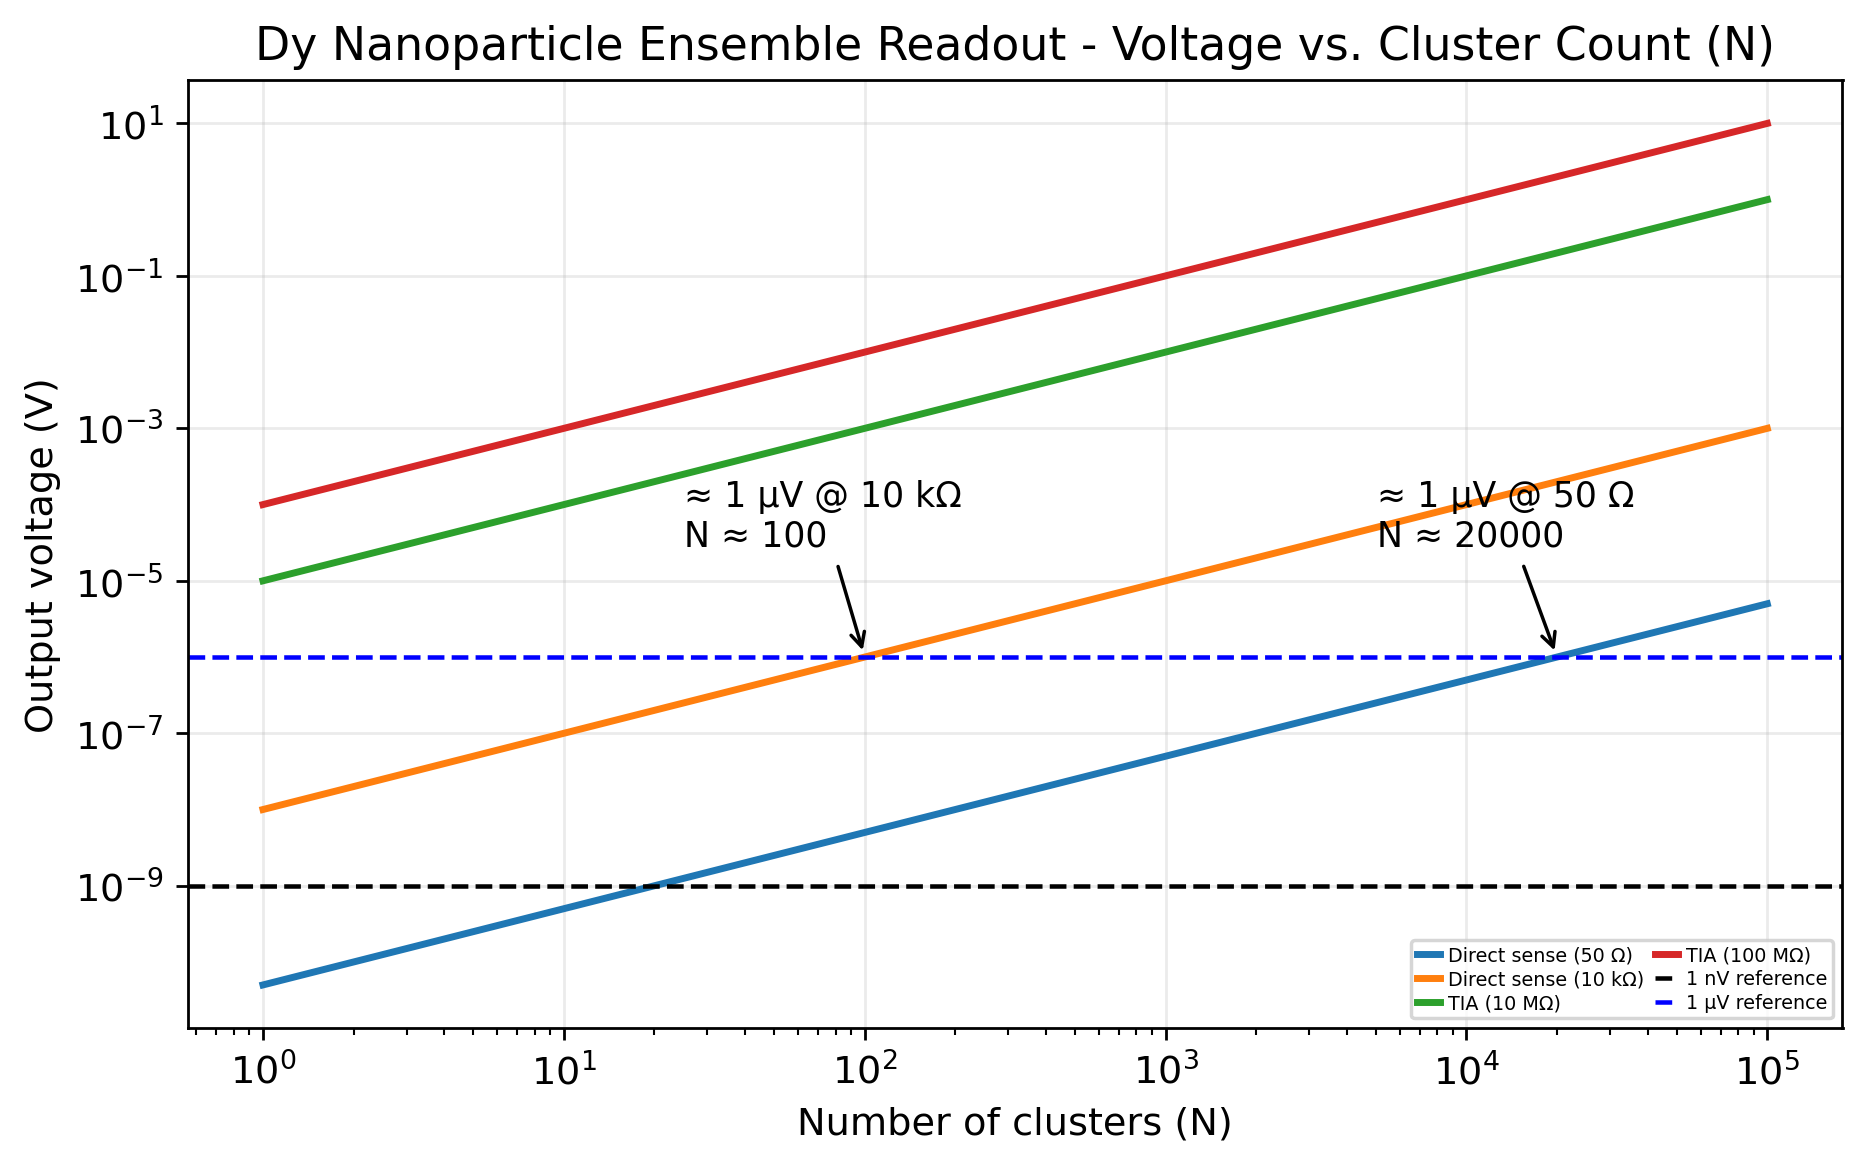

In [33]:
# Dy Nanoparticle Ensemble Readout — Voltage vs. Cluster Count (N)

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt


def predict_voltage_vs_clusters(
    i_per_cluster_a: float = 1e-12,
    r_50_ohm: float = 50.0,
    r_10k_ohm: float = 1.0e4,
    rf_10m_ohm: float = 1.0e7,
    rf_100m_ohm: float = 1.0e8,
    n_min: float = 1.0,
    n_max: float = 1.0e5,
    n_points: int = 400,
):
    """
    Compute output voltages versus the number of parallel clusters N
    for four readout configurations.
    Returns (N, V_50, V_10k, V_TIA10M, V_TIA100M).
    """
    n = np.logspace(np.log10(n_min), np.log10(n_max), int(n_points))
    v_50 = i_per_cluster_a * n * r_50_ohm
    v_10k = i_per_cluster_a * n * r_10k_ohm
    v_tia10 = i_per_cluster_a * n * rf_10m_ohm
    v_tia100 = i_per_cluster_a * n * rf_100m_ohm
    return n, v_50, v_10k, v_tia10, v_tia100


def _offset_points_at_angle(angle_deg: float, length_pts: float) -> tuple[float, float]:
    """
    Return (dx, dy) in points for a given visual angle and length.
    Note: annotate draws the arrow FROM the text TO the point (xy).
    To make the arrow itself point at `angle_deg`, the text must be
    placed at an offset of (angle_deg - 180°) from the point.
    """
    theta = np.deg2rad(angle_deg - 180.0)  # offset direction
    dx = length_pts * np.cos(theta)
    dy = length_pts * np.sin(theta)
    return dx, dy


def plot_voltage_scaling(
    n: np.ndarray,
    v_50: np.ndarray,
    v_10k: np.ndarray,
    v_tia10: np.ndarray,
    v_tia100: np.ndarray,
) -> None:
    """
    Arrows are constrained to 330° visual angle via 'offset points'.
    """
    # ---------- rcParams (200 dpi + tidy defaults) ----------
    mpl.rcParams["figure.dpi"] = 250
    mpl.rcParams["figure.figsize"] = (7.6, 4.8)
    mpl.rcParams["font.size"] = 11
    mpl.rcParams["axes.grid"] = True
    mpl.rcParams["grid.alpha"] = 0.25
    mpl.rcParams["lines.linewidth"] = 2.0
    mpl.rcParams["legend.frameon"] = True

    # ---------- Plot (single figure) ----------
    plt.figure()
    plt.plot(n, v_50,    label="Direct sense (50 Ω)")
    plt.plot(n, v_10k,   label="Direct sense (10 kΩ)")
    plt.plot(n, v_tia10, label="TIA (10 MΩ)")
    plt.plot(n, v_tia100,label="TIA (100 MΩ)")

    plt.xscale("log")
    plt.yscale("log")
    plt.xlabel("Number of clusters (N)")
    plt.ylabel("Output voltage (V)")
    plt.title("Dy Nanoparticle Ensemble Readout - Voltage vs. Cluster Count (N)")

    # Reference levels (you set explicit colors earlier; leaving them)
    v_nanov  = 1e-9
    v_microv = 1e-6
    plt.axhline(v_nanov,  color="black", linestyle="--", linewidth=1.3, label="1 nV reference")
    plt.axhline(v_microv, color="blue",  linestyle="--", linewidth=1.3, label="1 µV reference")

    # Targets where the direct-sense curves hit 1 µV
    i1 = 1e-12
    n_uv_50  = v_microv / (i1 * 50.0)
    n_uv_10k = v_microv / (i1 * 1.0e4)

    # ----- Place arrows at 330° visual angle -----
    ARROW_ANGLE_DEG = 330
    ARROW_LEN_PTS   = 60.0  # length of the offset in points (tweak to taste)
    dx, dy = _offset_points_at_angle(ARROW_ANGLE_DEG, ARROW_LEN_PTS)

    plt.annotate(
        f"≈ 1 µV @ 50 Ω\nN ≈ {n_uv_50:.0f}",
        xy=(n_uv_50, v_microv),
        xytext=(dx, dy),
        textcoords="offset points",   # angle measured in screen points
        arrowprops=dict(arrowstyle="->", lw=1.0),
        ha="left", va="bottom",       # readable placement; adjust as desired
        fontsize=10,
    )
    plt.annotate(
        f"≈ 1 µV @ 10 kΩ\nN ≈ {n_uv_10k:.0f}",
        xy=(n_uv_10k, v_microv),
        xytext=(dx, dy),
        textcoords="offset points",
        arrowprops=dict(arrowstyle="->", lw=1.0),
        ha="left", va="bottom",
        fontsize=10,
    )

    # Smaller legend (~0.5×), with tighter spacing to match scale
    plt.legend(
        loc="lower right", ncol=2,
        fontsize=_legend_fs,
        labelspacing=0.25,    # vertical spacing between entries
        handlelength=1.2,     # length of line handles
        handletextpad=0.4,    # gap between handle and text
        borderpad=0.3,        # padding inside the legend frame
        columnspacing=0.6,    # gap between legend columns
        markerscale=0.8       # in case markers are present later
    )

    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    N, V_50, V_10k, V_TIA10, V_TIA100 = predict_voltage_vs_clusters(i_per_cluster_a=1e-12)
    plot_voltage_scaling(N, V_50, V_10k, V_TIA10, V_TIA100)

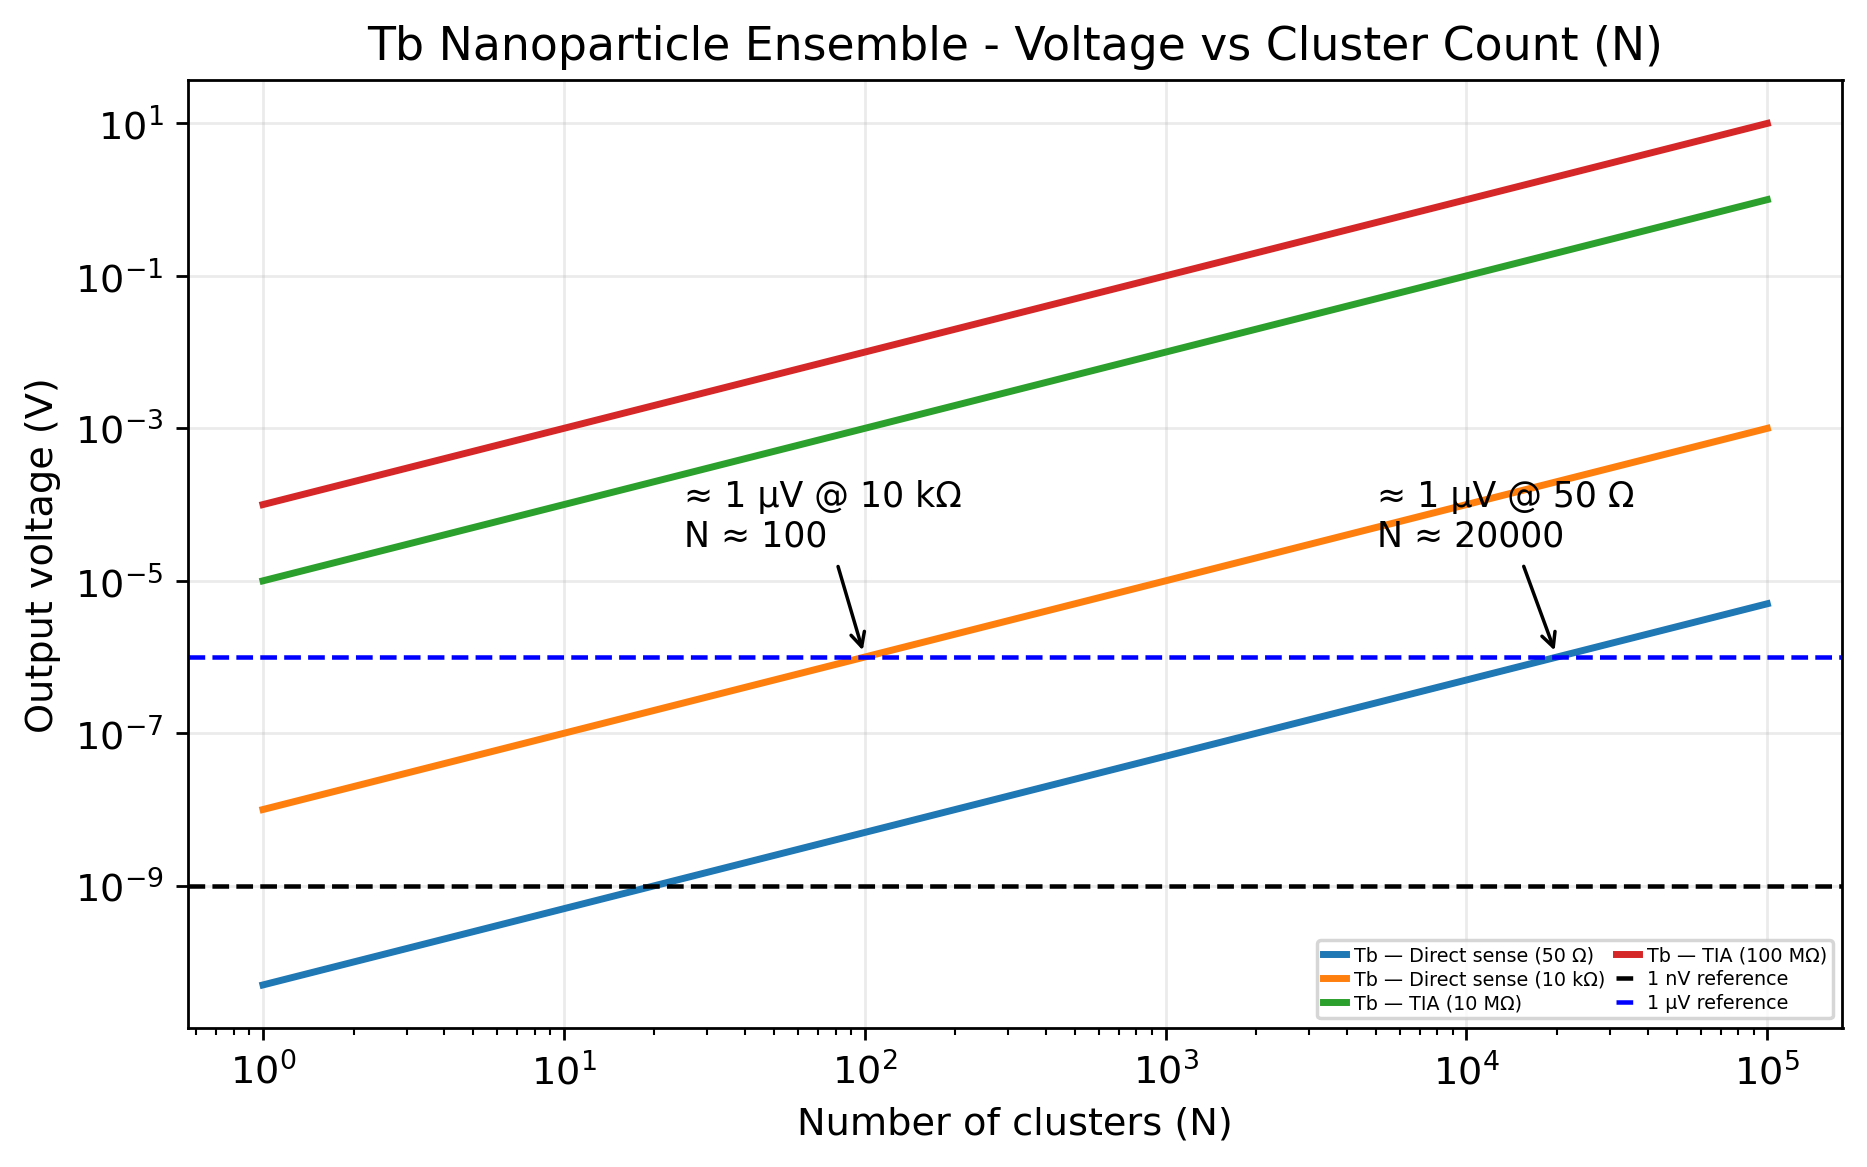

In [36]:
# Tb-only
# Shows output voltage vs number of clusters N for four readout configurations.

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# ---------- Tunables ----------
I1_TB_A   = 1e-12   # Per-cluster current for Tb at readout alignment (A); adjust to your measured value
N_MIN     = 1.0
N_MAX     = 1.0e5
N_POINTS  = 400
R_50      = 50.0    # Ohms
R_10K     = 1.0e4   # Ohms
RF_10M    = 1.0e7   # Ohms
RF_100M   = 1.0e8   # Ohms

# ---------- Helpers ----------
def predict_voltage_vs_clusters(i_per_cluster_a: float,
                                r_50_ohm: float,
                                r_10k_ohm: float,
                                rf_10m_ohm: float,
                                rf_100m_ohm: float,
                                n_min: float,
                                n_max: float,
                                n_points: int):
    """Return (N, V_50, V_10k, V_TIA10M, V_TIA100M) for given parameters."""
    n = np.logspace(np.log10(n_min), np.log10(n_max), int(n_points))
    v_50 = i_per_cluster_a * n * r_50_ohm
    v_10k = i_per_cluster_a * n * r_10k_ohm
    v_tia10 = i_per_cluster_a * n * rf_10m_ohm
    v_tia100 = i_per_cluster_a * n * rf_100m_ohm
    return n, v_50, v_10k, v_tia10, v_tia100

def _offset_points_at_angle(angle_deg: float, length_pts: float) -> tuple[float, float]:
    """
    Offset (dx, dy) in display points so that the arrow from text→point has angle 'angle_deg' visually.
    annotate() draws the arrow from the text to the point, so we place the text opposite that direction.
    """
    theta = np.deg2rad(angle_deg - 180.0)
    return (length_pts * np.cos(theta), length_pts * np.sin(theta))

# ---------- rcParams (250 dpi; single chart) ----------
mpl.rcParams["figure.dpi"] = 250
mpl.rcParams["figure.figsize"] = (7.6, 4.8)
mpl.rcParams["font.size"] = 11
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.25
mpl.rcParams["lines.linewidth"] = 2.0
mpl.rcParams["legend.frameon"] = True

# ---------- Compute (Tb only) ----------
N, V_50, V_10k, V_TIA10, V_TIA100 = predict_voltage_vs_clusters(
    I1_TB_A, R_50, R_10K, RF_10M, RF_100M, N_MIN, N_MAX, N_POINTS
)

# ---------- Plot ----------
plt.figure()
plt.plot(N, V_50,    label="Tb — Direct sense (50 Ω)")
plt.plot(N, V_10k,   label="Tb — Direct sense (10 kΩ)")
plt.plot(N, V_TIA10, label="Tb — TIA (10 MΩ)")
plt.plot(N, V_TIA100,label="Tb — TIA (100 MΩ)")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of clusters (N)")
plt.ylabel("Output voltage (V)")
plt.title("Tb Nanoparticle Ensemble - Voltage vs Cluster Count (N)")

# Reference levels (no explicit colors)
v_nanov  = 1e-9
v_microv = 1e-6
plt.axhline(v_nanov,  color="black", linestyle="--", linewidth=1.3, label="1 nV reference")
plt.axhline(v_microv, color="blue", linestyle="--", linewidth=1.3, label="1 µV reference")

# 135° visual-angle arrows to highlight 1 µV intercepts for direct-sense paths
i1 = I1_TB_A
n_uv_50  = v_microv / (i1 * R_50)
n_uv_10k = v_microv / (i1 * R_10K)
dx, dy = _offset_points_at_angle(330.0, 60.0)

plt.annotate(
    f"≈ 1 µV @ 50 Ω\nN ≈ {n_uv_50:.0f}",
    xy=(n_uv_50, v_microv),
    xytext=(dx, dy),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", lw=1.0),
    ha="left", va="bottom",
    fontsize=10,
)
plt.annotate(
    f"≈ 1 µV @ 10 kΩ\nN ≈ {n_uv_10k:.0f}",
    xy=(n_uv_10k, v_microv),
    xytext=(dx, dy),
    textcoords="offset points",
    arrowprops=dict(arrowstyle="->", lw=1.0),
    ha="left", va="bottom",
    fontsize=10,
)

# Smaller legend (~0.5×), with tighter spacing to match scale
plt.legend(
    loc="lower right", ncol=2,
    fontsize=_legend_fs,
    labelspacing=0.25,    # vertical spacing between entries
    handlelength=1.2,     # length of line handles
    handletextpad=0.4,    # gap between handle and text
    borderpad=0.3,        # padding inside the legend frame
    columnspacing=0.6,    # gap between legend columns
    markerscale=0.8       # in case markers are present later
)

plt.tight_layout()
plt.show()

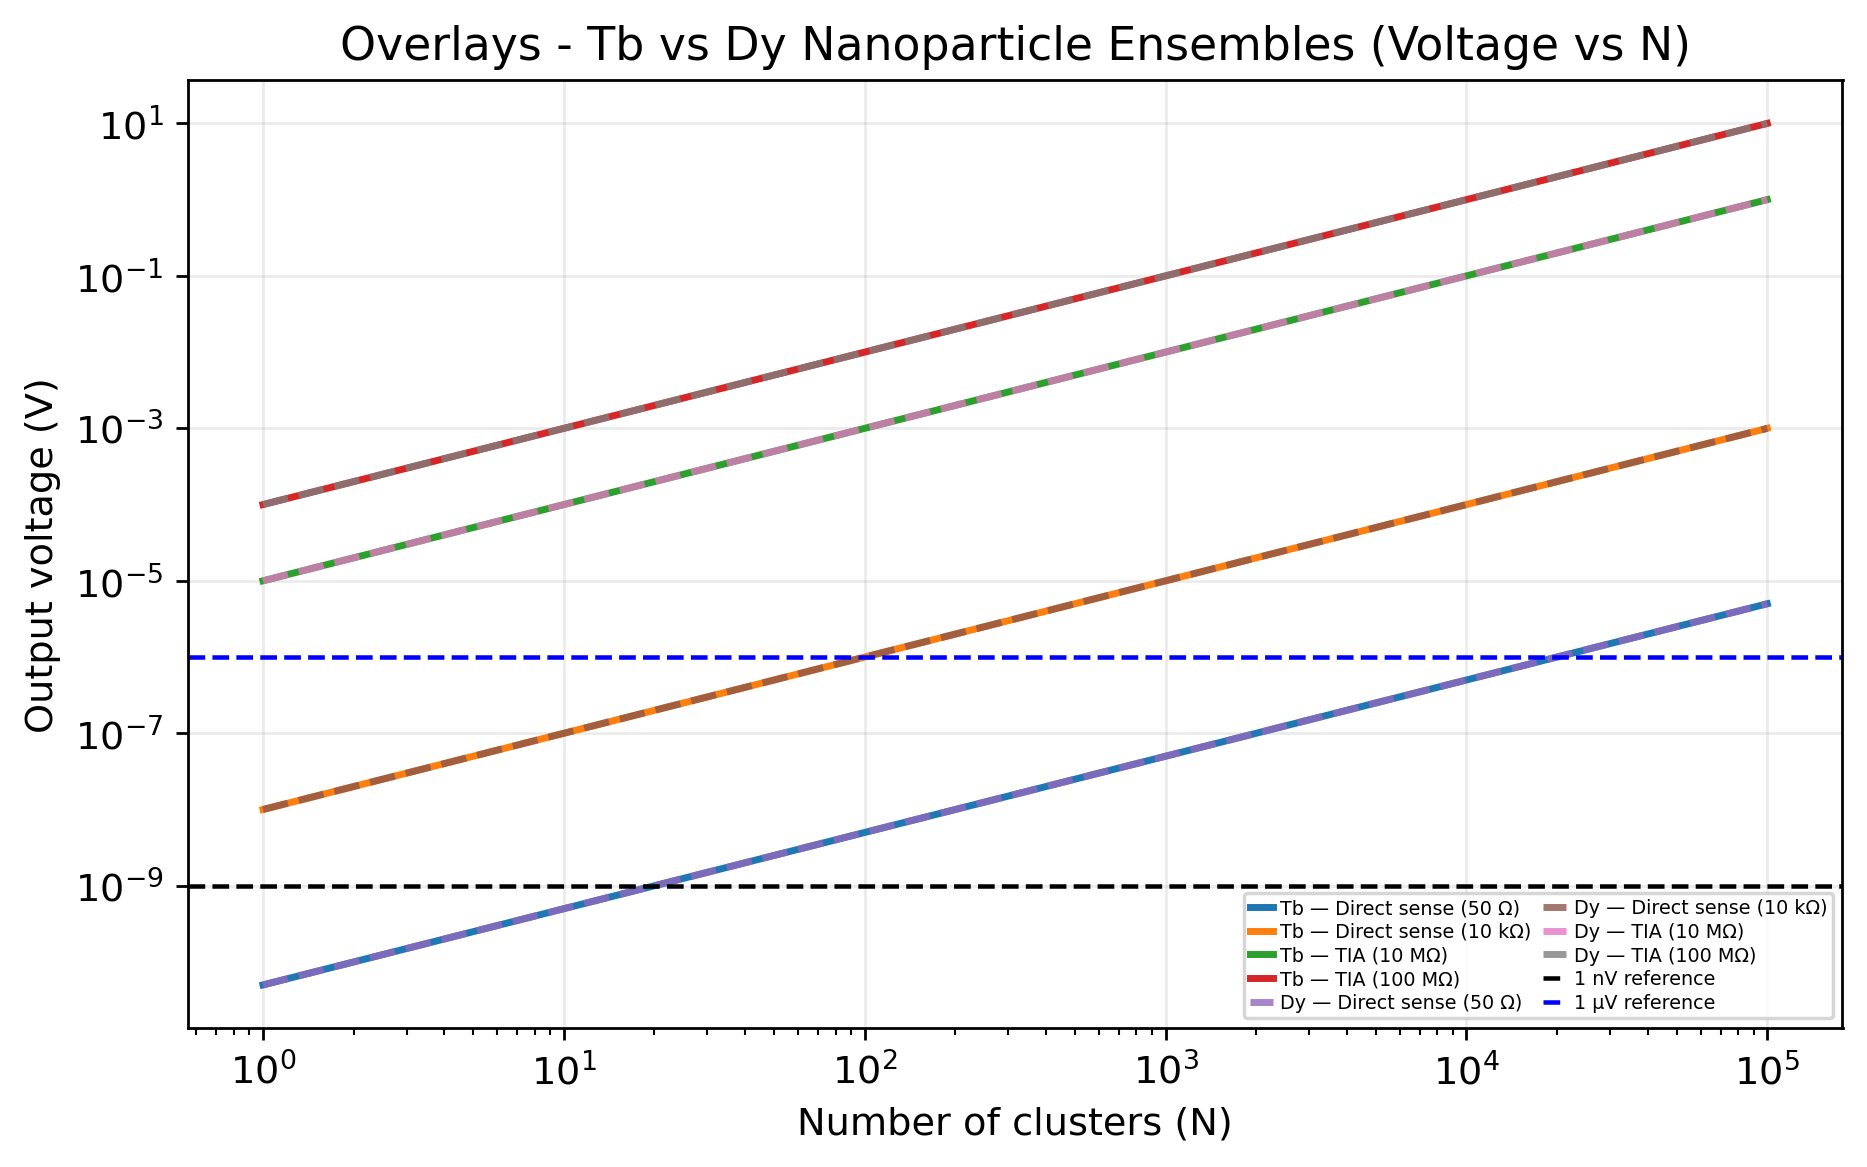

In [37]:
# Overlays (Tb vs Dy); same geometry and I1 baseline by default.
# Four readout configurations for each metal are plotted (8 curves total).

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# ---------- Tunables ----------
I1_TB_A = 1e-12   # A per Tb cluster at readout alignment
I1_DY_A = 1e-12   # A per Dy cluster at readout alignment (set equal to show near-identity)
N_MIN     = 1.0
N_MAX     = 1.0e5
N_POINTS  = 400
R_50      = 50.0
R_10K     = 1.0e4
RF_10M    = 1.0e7
RF_100M   = 1.0e8

def predict_voltage_vs_clusters(i_per_cluster_a: float,
                                r_50_ohm: float,
                                r_10k_ohm: float,
                                rf_10m_ohm: float,
                                rf_100m_ohm: float,
                                n_min: float,
                                n_max: float,
                                n_points: int):
    n = np.logspace(np.log10(n_min), np.log10(n_max), int(n_points))
    v_50 = i_per_cluster_a * n * r_50_ohm
    v_10k = i_per_cluster_a * n * r_10k_ohm
    v_tia10 = i_per_cluster_a * n * rf_10m_ohm
    v_tia100 = i_per_cluster_a * n * rf_100m_ohm
    return n, v_50, v_10k, v_tia10, v_tia100

# ---------- rcParams (250 dpi; single chart) ----------
mpl.rcParams["figure.dpi"] = 250
mpl.rcParams["figure.figsize"] = (7.6, 4.8)
mpl.rcParams["font.size"] = 11
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.25
mpl.rcParams["lines.linewidth"] = 2.0
mpl.rcParams["legend.frameon"] = True

# Legend scale (~0.5× of base font size)
LEGEND_SCALE = 0.5
_base_fs = mpl.rcParams["font.size"]
_legend_fs = _base_fs * LEGEND_SCALE

# ---------- Compute ----------
N_tb, V50_tb, V10k_tb, Vtia10_tb, Vtia100_tb = predict_voltage_vs_clusters(
    I1_TB_A, R_50, R_10K, RF_10M, RF_100M, N_MIN, N_MAX, N_POINTS
)
N_dy, V50_dy, V10k_dy, Vtia10_dy, Vtia100_dy = predict_voltage_vs_clusters(
    I1_DY_A, R_50, R_10K, RF_10M, RF_100M, N_MIN, N_MAX, N_POINTS
)

# ---------- Plot (Overlays) ----------
plt.figure()
# Tb curves (solid)
plt.plot(N_tb, V50_tb,     linestyle='-',  label="Tb — Direct sense (50 Ω)")
plt.plot(N_tb, V10k_tb,    linestyle='-',  label="Tb — Direct sense (10 kΩ)")
plt.plot(N_tb, Vtia10_tb,  linestyle='-',  label="Tb — TIA (10 MΩ)")
plt.plot(N_tb, Vtia100_tb, linestyle='-',  label="Tb — TIA (100 MΩ)")

# Dy curves (dashed), slight transparency to see overlap
plt.plot(N_dy, V50_dy,     linestyle='--', alpha=0.8, label="Dy — Direct sense (50 Ω)")
plt.plot(N_dy, V10k_dy,    linestyle='--', alpha=0.8, label="Dy — Direct sense (10 kΩ)")
plt.plot(N_dy, Vtia10_dy,  linestyle='--', alpha=0.8, label="Dy — TIA (10 MΩ)")
plt.plot(N_dy, Vtia100_dy, linestyle='--', alpha=0.8, label="Dy — TIA (100 MΩ)")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of clusters (N)")
plt.ylabel("Output voltage (V)")
plt.title("Overlays - Tb vs Dy Nanoparticle Ensembles (Voltage vs N)")

# Reference lines
v_nanov  = 1e-9
v_microv = 1e-6
plt.axhline(v_nanov,  linestyle="--", color="black", linewidth=1.3, label="1 nV reference")
plt.axhline(v_microv, linestyle="--", color="blue",  linewidth=1.3, label="1 µV reference")

# Smaller legend (~0.5×), with tighter spacing to match scale
plt.legend(
    loc="lower right", ncol=2,
    fontsize=_legend_fs,
    labelspacing=0.25,    # vertical spacing between entries
    handlelength=1.2,     # length of line handles
    handletextpad=0.4,    # gap between handle and text
    borderpad=0.3,        # padding inside the legend frame
    columnspacing=0.6,    # gap between legend columns
    markerscale=0.8       # in case markers are present later
)

plt.tight_layout()
plt.show()

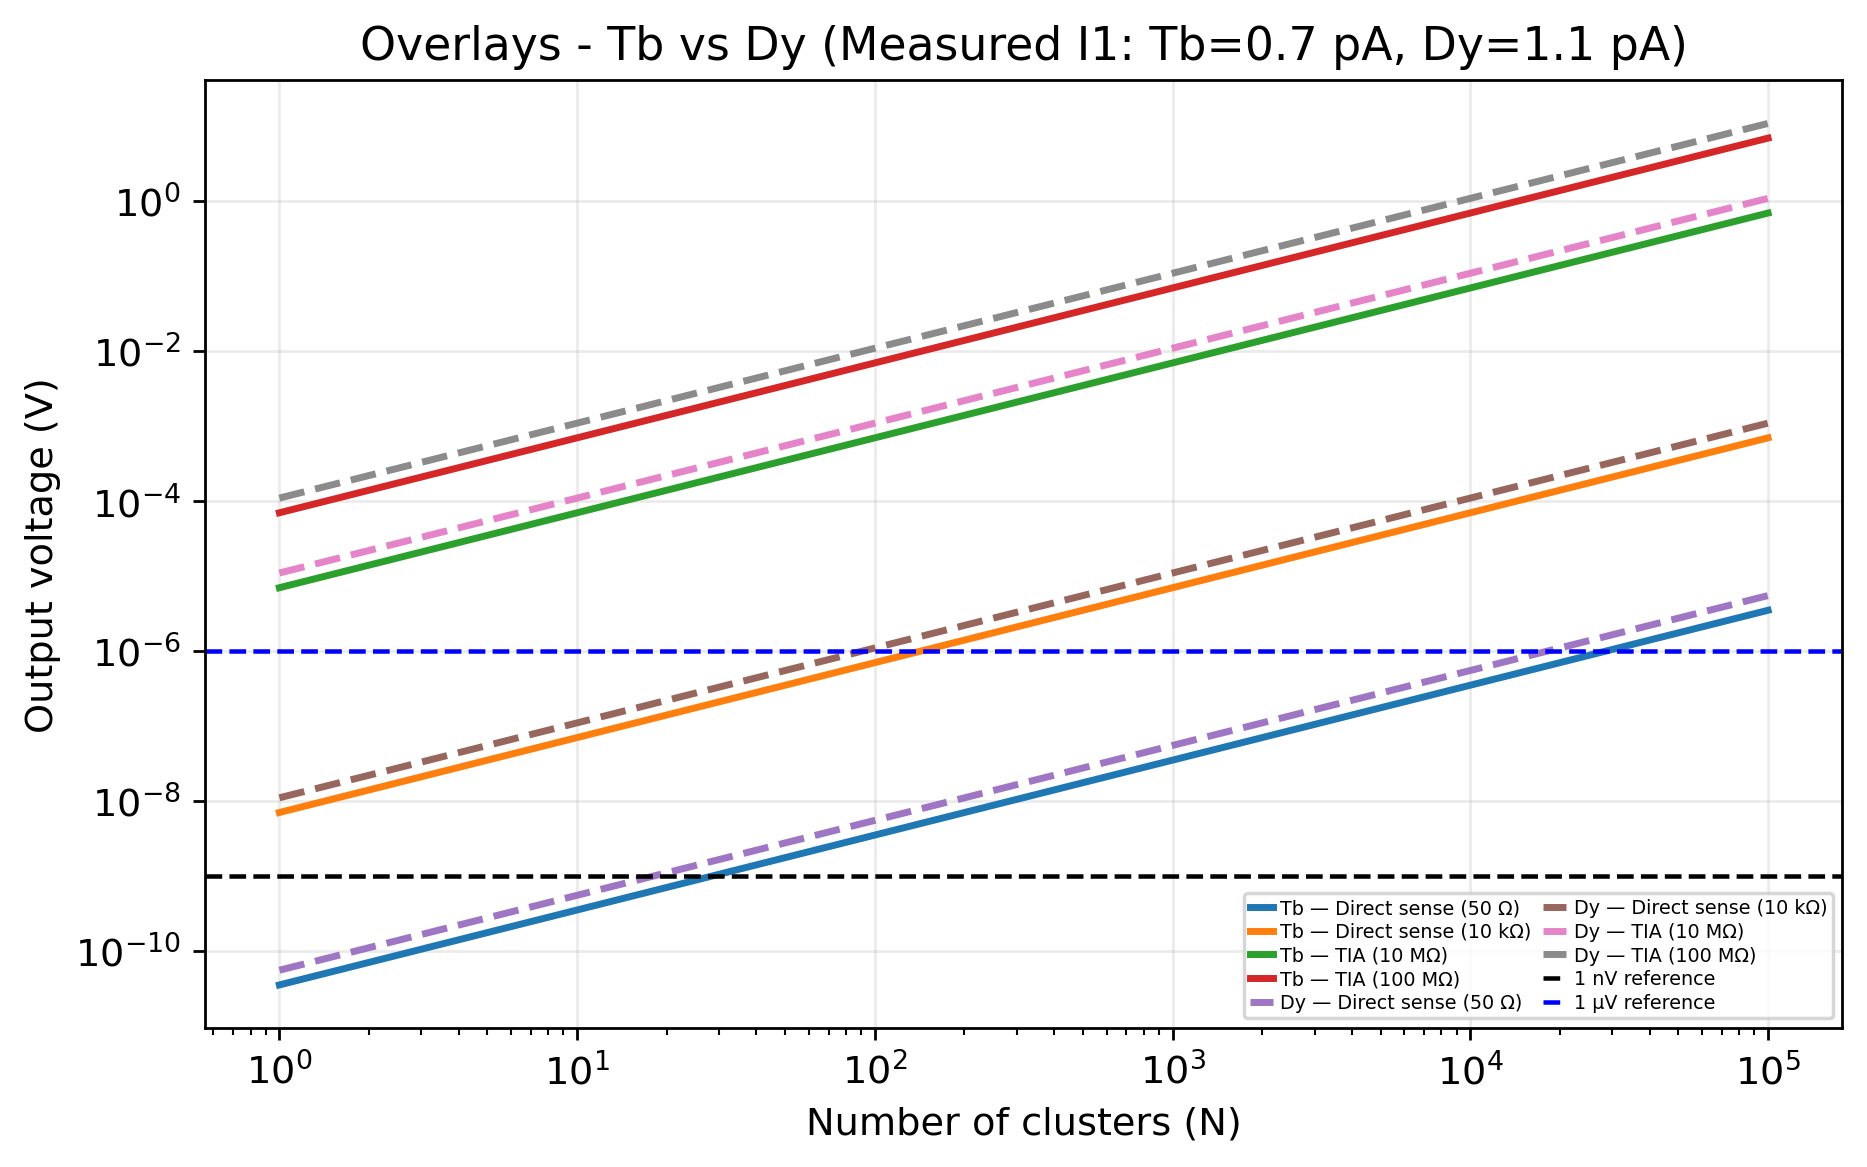

In [40]:
# Overlays (Tb vs Dy) with measured single-cluster currents:
# I1_Tb = 0.7 pA, I1_Dy = 1.1 pA. Legend scaled to ~0.5×.

import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt

# ---------- Tunables (measured currents) ----------
I1_TB_A = 0.7e-12   # 0.7 pA per Tb cluster
I1_DY_A = 1.1e-12   # 1.1 pA per Dy cluster
N_MIN, N_MAX, N_POINTS = 1.0, 1.0e5, 400
R_50, R_10K, RF_10M, RF_100M = 50.0, 1.0e4, 1.0e7, 1.0e8

def predict_voltage_vs_clusters(i_per_cluster_a, r_50_ohm, r_10k_ohm, rf_10m_ohm, rf_100m_ohm,
                                n_min, n_max, n_points):
    n = np.logspace(np.log10(n_min), np.log10(n_max), int(n_points))
    v_50    = i_per_cluster_a * n * r_50_ohm
    v_10k   = i_per_cluster_a * n * r_10k_ohm
    v_tia10 = i_per_cluster_a * n * rf_10m_ohm
    v_tia100= i_per_cluster_a * n * rf_100m_ohm
    return n, v_50, v_10k, v_tia10, v_tia100

# ---------- rcParams (250 dpi) ----------
mpl.rcParams["figure.dpi"] = 250
mpl.rcParams["figure.figsize"] = (7.6, 4.8)
mpl.rcParams["font.size"] = 11
mpl.rcParams["axes.grid"] = True
mpl.rcParams["grid.alpha"] = 0.25
mpl.rcParams["lines.linewidth"] = 2.0
mpl.rcParams["legend.frameon"] = True

# Smaller legend (~0.5× of base font size)
LEGEND_SCALE = 0.5
_legend_fs = mpl.rcParams["font.size"] * LEGEND_SCALE

# ---------- Compute ----------
N_tb, V50_tb, V10k_tb, Vtia10_tb, Vtia100_tb = predict_voltage_vs_clusters(
    I1_TB_A, R_50, R_10K, RF_10M, RF_100M, N_MIN, N_MAX, N_POINTS
)
N_dy, V50_dy, V10k_dy, Vtia10_dy, Vtia100_dy = predict_voltage_vs_clusters(
    I1_DY_A, R_50, R_10K, RF_10M, RF_100M, N_MIN, N_MAX, N_POINTS
)

# ---------- Plot (Overlays) ----------
plt.figure()
# Tb curves (solid)
plt.plot(N_tb, V50_tb,     linestyle='-',  label="Tb — Direct sense (50 Ω)")
plt.plot(N_tb, V10k_tb,    linestyle='-',  label="Tb — Direct sense (10 kΩ)")
plt.plot(N_tb, Vtia10_tb,  linestyle='-',  label="Tb — TIA (10 MΩ)")
plt.plot(N_tb, Vtia100_tb, linestyle='-',  label="Tb — TIA (100 MΩ)")

# Dy curves (dashed), slight transparency to separate visually
plt.plot(N_dy, V50_dy,     linestyle='--', alpha=0.9, label="Dy — Direct sense (50 Ω)")
plt.plot(N_dy, V10k_dy,    linestyle='--', alpha=0.9, label="Dy — Direct sense (10 kΩ)")
plt.plot(N_dy, Vtia10_dy,  linestyle='--', alpha=0.9, label="Dy — TIA (10 MΩ)")
plt.plot(N_dy, Vtia100_dy, linestyle='--', alpha=0.9, label="Dy — TIA (100 MΩ)")

plt.xscale("log")
plt.yscale("log")
plt.xlabel("Number of clusters (N)")
plt.ylabel("Output voltage (V)")
plt.title("Overlays - Tb vs Dy (Measured I1: Tb=0.7 pA, Dy=1.1 pA)")

# Reference lines
v_nanov, v_microv = 1e-9, 1e-6
plt.axhline(v_nanov,  linestyle="--", color="black", linewidth=1.3, label="1 nV reference")
plt.axhline(v_microv, linestyle="--", color="blue",  linewidth=1.3, label="1 µV reference")

plt.legend(
    loc="lower right", ncol=2,
    fontsize=_legend_fs,
    labelspacing=0.25, handlelength=1.2, handletextpad=0.4,
    borderpad=0.3, columnspacing=0.6, markerscale=0.8
)

plt.tight_layout()
plt.show()